In [1]:
from sklearn.model_selection import KFold
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools

# ---- Load and Preprocess Data ----
train_dir = 'D:/Lung_cancer/train'  # Training directory path
target_size = (224, 224)  # Input size for InceptionResNetV2
num_classes = 3

# Extract file paths and labels
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,  # Temporary batch size
    class_mode='categorical',
    shuffle=False  # To keep track of indices
)
X = np.array(train_generator.filepaths)  # File paths of images
y = np.array(train_generator.classes)    # Corresponding class labels

# ---- Hyperparameter tuning Search Space method ----
batch_sizes = [16, 32]
dropout_rates = [0.3, 0.5]
learning_rates = [0.0005, 0.001]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_params = {}
best_accuracy = 0

# Iterate over all combinations of hyperparameters
for batch_size, dropout_rate, learning_rate in itertools.product(batch_sizes, dropout_rates, learning_rates):
    print(f"Testing batch_size={batch_size}, dropout={dropout_rate}, lr={learning_rate}")
    
    fold_accuracies = []
    fold_losses = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}")
        
        # Split into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Load data dynamically
        def load_data(file_paths, labels):
            images = []
            for file in file_paths:
                img = load_img(file, target_size=target_size)
                img = img_to_array(img)
                images.append(img)
            images = np.array(images) / 255.0
            labels = np.eye(num_classes)[labels]
            return images, labels
        
        X_train_images, y_train_labels = load_data(X_train, y_train)
        X_val_images, y_val_labels = load_data(X_val, y_val)
        
        # ---- Define and Compile Model ----
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False
        
        x = base_model.output
        x = layers.Reshape(target_shape=(-1, x.shape[-1]))(x)  # Reshape to (batch, time_steps, features) for GRU
        x = layers.GRU(256, return_sequences=True)(x)
        x = layers.GRU(128)(x)  # Final GRU layer
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        output = layers.Dense(num_classes, activation='softmax')(x)
        model = models.Model(inputs=base_model.input, outputs=output)
        
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # ---- Train Model ----
        history = model.fit(
            X_train_images, y_train_labels,
            validation_data=(X_val_images, y_val_labels),
            epochs=10,  # Default to 10 epochs
            batch_size=batch_size,
            verbose=1
        )
        
        # ---- Evaluate Model ----
        val_loss, val_accuracy = model.evaluate(X_val_images, y_val_labels, verbose=0)
        print(f"Fold {fold + 1} Accuracy: {val_accuracy * 100:.2f}%")
        print(f"Fold {fold + 1} Loss: {val_loss:.4f}")
        
        fold_accuracies.append(val_accuracy)
        fold_losses.append(val_loss)
    
    # Compute mean accuracy for the current hyperparameter combination
    mean_accuracy = np.mean(fold_accuracies)
    mean_loss = np.mean(fold_losses)
    
    print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%, Mean Loss: {mean_loss:.4f}\n")
    
    # Store best hyperparameters
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = {
            "batch_size": batch_size,
            "dropout": dropout_rate,
            "learning_rate": learning_rate,
            "accuracy": best_accuracy
        }

# ---- Final Best Parameters ----
print("Best Parameters:")
print(best_params)


Found 406 images belonging to 3 classes.
Testing batch_size=16, dropout=0.3, lr=0.0005

Fold 1

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3561 - loss: 1.1376 - val_accuracy: 0.5000 - val_loss: 0.9582
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5583 - loss: 0.9164 - val_accuracy: 0.7195 - val_loss: 0.7743
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7400 - loss: 0.6182 - val_accuracy: 0.7439 - val_loss: 0.6868
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8161 - loss: 0.4486 - val_accuracy: 0.6707 - val_loss: 0.8127
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8618 - loss: 0.3294 - val_accuracy: 0.7439 - val_loss: 0.6454
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9608 - loss: 0.1379 - val_accuracy: 0.6585 - val_loss: 1.1154
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8273 - loss: 0.4683 - val_accuracy: 0.6463 - val_loss: 0.8188
Epoch 8/10
21/21 ━━━━━

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

# ---- Paths ----
train_dir = 'D:/Lung_cancer/train'
val_dir = 'D:/Lung_cancer/LC25000_sampled'
test_dir = 'D:/Lung_cancer/test'

# ---- Hyperparameters ----
batch_size = 16
dropout_rate = 0.5
learning_rate = 0.001
target_size = (299, 299)  # InceptionResNetV2 input size
num_classes = 3  # Assuming 3 classes for lung cancer

# ---- Data Preprocessing ----
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=True
)
val_generator = datagen.flow_from_directory(
    val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)
test_generator = datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

def build_model(base_model):
    base_model.trainable = False  # Freeze base layers
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    
    # Reshape for GRU (Batch, TimeSteps, Features)
    x = layers.Reshape((1, x.shape[-1]))(x)  
    
    # Add GRU Layer
    x = layers.GRU(256, return_sequences=False, dropout=dropout_rate, recurrent_dropout=0.2)(x)
    
    # Fully connected layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs=base_model.input, outputs=output)

# ---- InceptionResNetV2 + GRU Model ----
inception_resnet_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
model = build_model(inception_resnet_base)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTraining InceptionResNetV2 + GRU Model...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=batch_size,
    verbose=1
)

# ---- Evaluate Model ----
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"InceptionResNetV2 + GRU Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"InceptionResNetV2 + GRU Test Loss: {test_loss:.4f}")

# Evaluate for training
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the final model
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")


Found 406 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 103 images belonging to 3 classes.


Training InceptionResNetV2 + GRU Model...


C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 263s 10s/step - accuracy: 0.4245 - loss: 1.0738 - val_accuracy: 0.6627 - val_loss: 0.7528
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 243s 10s/step - accuracy: 0.5337 - loss: 0.8914 - val_accuracy: 0.8633 - val_loss: 0.4745
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 244s 10s/step - accuracy: 0.6786 - loss: 0.6942 - val_accuracy: 0.8220 - val_loss: 0.4367
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 242s 10s/step - accuracy: 0.7697 - loss: 0.5586 - val_accuracy: 0.8107 - val_loss: 0.5015
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 244s 10s/step - accuracy: 0.7768 - loss: 0.5515 - val_accuracy: 0.7920 - val_loss: 0.4981
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 242s 10s/step - accuracy: 0.8250 - loss: 0.4803 - val_accuracy: 0.7633 - val_loss: 0.5231
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 242s 10s/step - accuracy: 0.8109 - loss: 0.4790 - val_accuracy: 0.8113 - val_loss: 0.5228
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 243s 10s/step - accuracy: 0.8095 - loss: 0.4114 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.93
Nor - AUC: 0.94
Squamous_carcinoma - AUC: 0.95


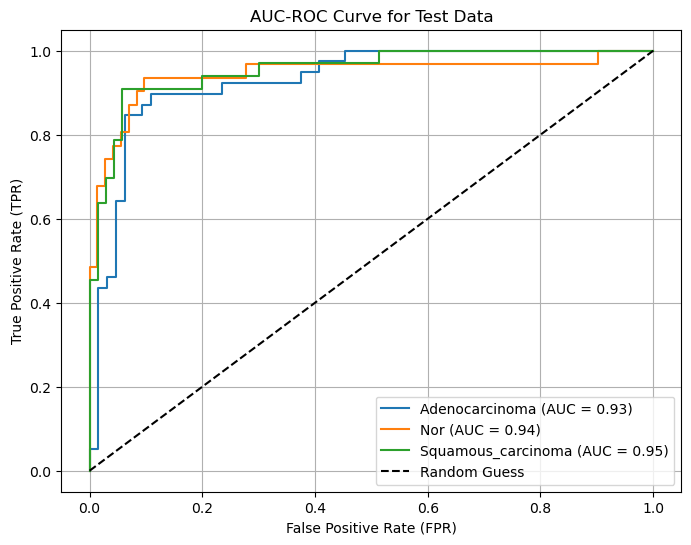


Macro-Averaged Test AUC: 0.94


In [4]:
# Predict probabilities for the test dataset
test_predictions =model.predict(test_generator, verbose=1)

# True labels from the test generator
test_true_labels = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
test_true_labels_binarized = label_binarize(test_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Test Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(test_true_labels_binarized, test_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

In [2]:
# Predict probabilities for the test dataset
val_predictions =model.predict(val_generator, verbose=1)

# True labels from the test generator
val_true_labels = val_generator.classes  # True class labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
val_true_labels_binarized = label_binarize(val_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Ex val Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(val_true_labels_binarized, val_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

NameError: name 'model' is not defined

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step

=== Test Metrics ===
Accuracy      : 81.55%
Precision     : 82.93%
Recall        : 81.55%
F1-Score      : 81.57%

Classification Report:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.73      0.90      0.80        39
               Nor       0.88      0.71      0.79        31
Squamous_carcinoma       0.90      0.82      0.86        33

          accuracy                           0.82       103
         macro avg       0.84      0.81      0.82       103
      weighted avg       0.83      0.82      0.82       103


=== Validation Metrics ===
Accuracy      : 83.87%
Precision     : 84.11%
Recall        : 83.87%
F1-Score      : 83.93%

Classification Report:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.74      0.80      0.77       500
               Nor       0.99      0.97      0.98       500
Squamous_carcinoma       0.80      0.

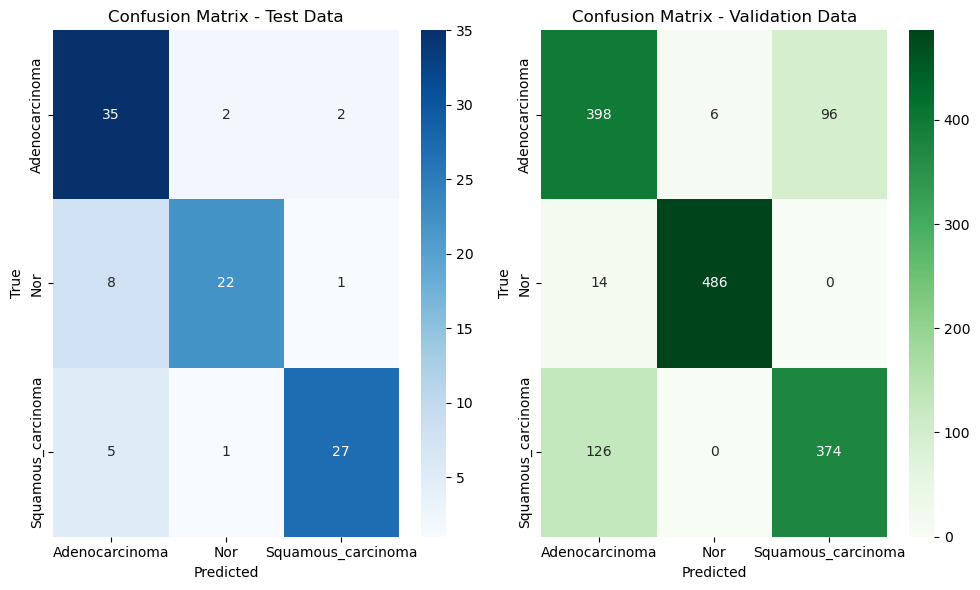

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Function to get true and predicted labels ----
def get_true_and_pred_labels(generator, model):
    true_labels = generator.classes
    pred_probs = model.predict(generator, verbose=1)
    pred_labels = np.argmax(pred_probs, axis=1)
    return true_labels, pred_labels

# ---- Get Test and Validation Labels ----
true_test_labels, pred_test_labels = get_true_and_pred_labels(test_generator, model)
true_val_labels, pred_val_labels = get_true_and_pred_labels(val_generator, model)

# ---- Evaluation Metrics Function ----
def print_metrics(true_labels, pred_labels, dataset_name):
    acc = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    
    print(f"\n=== {dataset_name} Metrics ===")
    print(f"Accuracy      : {acc * 100:.2f}%")
    print(f"Precision     : {precision * 100:.2f}%")
    print(f"Recall        : {recall * 100:.2f}%")
    print(f"F1-Score      : {f1 * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=list(test_generator.class_indices.keys())))

# ---- Print Metrics for Test and Validation Sets ----
print_metrics(true_test_labels, pred_test_labels, "Test")
print_metrics(true_val_labels, pred_val_labels, "Validation")

# ---- Confusion Matrices ----
cm_test = confusion_matrix(true_test_labels, pred_test_labels)
cm_val = confusion_matrix(true_val_labels, pred_val_labels)

# ---- Plot Confusion Matrices ----
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix - External validation Data')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import os

# Define a function to collect metrics
def collect_metrics(model_name, true_labels, pred_labels, dataset_name):
    acc = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    
    metrics = {
        'Model': model_name,
        'Dataset': dataset_name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    }
    return metrics

# Collect metrics for test and validation datasets
metrics_test = collect_metrics("InceptionResNetV2_GRU", true_test_labels, pred_test_labels, "Test")
metrics_val = collect_metrics("InceptionResNetV2_GRU", true_val_labels, pred_val_labels, "Validation")

# Combine into a DataFrame
metrics_df = pd.DataFrame([metrics_test, metrics_val])

# Save to CSV
save_path = 'model_comparison_metrics.csv'

# If file exists, append new metrics
if os.path.exists(save_path):
    existing_df = pd.read_csv(save_path)
    metrics_df = pd.concat([existing_df, metrics_df], ignore_index=True)

metrics_df.to_csv(save_path, index=False)

print(f"\n✅ Metrics saved to {save_path}")



✅ Metrics saved to model_comparison_metrics.csv


In [18]:
model.save("InceptionResNetV2+GRu_5FCV_updated.keras")

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.92
Nor - AUC: 0.94
Squamous_carcinoma - AUC: 0.95


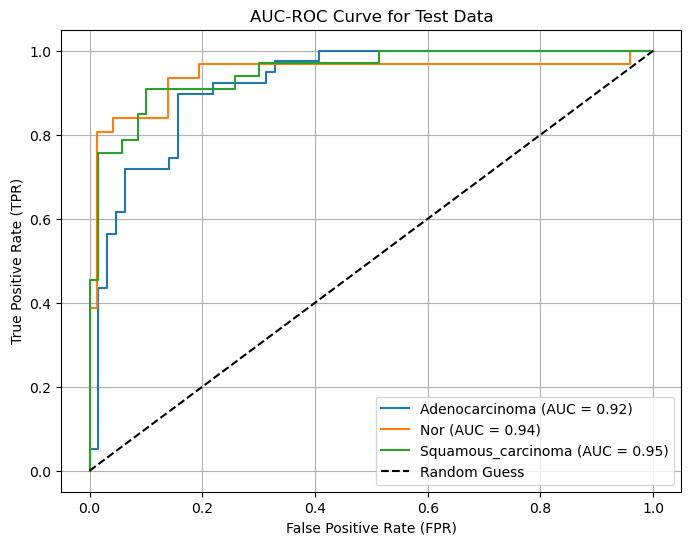


Macro-Averaged Test AUC: 0.94


In [4]:
# Predict probabilities for the test dataset
test_predictions =model.predict(test_generator, verbose=1)

# True labels from the test generator
test_true_labels = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
test_true_labels_binarized = label_binarize(test_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Test Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(test_true_labels_binarized, test_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.87
Nor - AUC: 1.00
Squamous_carcinoma - AUC: 0.92


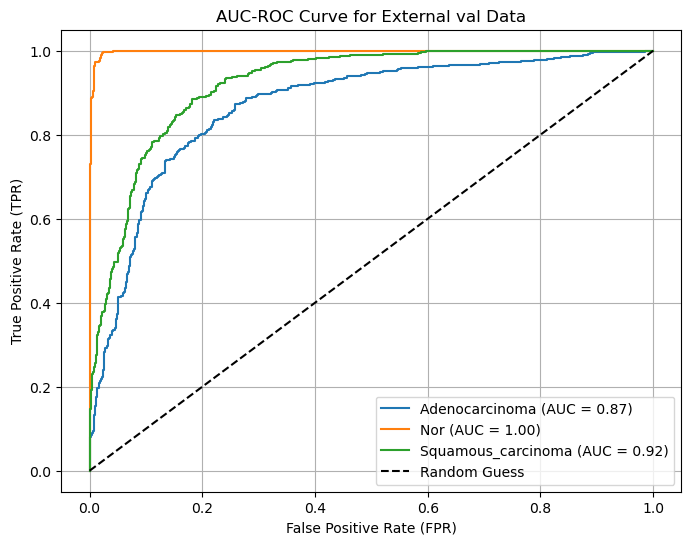


Macro-Averaged External val AUC: 0.93


In [6]:
# Predict probabilities for the test dataset
val_predictions =model.predict(val_generator, verbose=1)

# True labels from the test generator
val_true_labels = val_generator.classes  # True class labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
val_true_labels_binarized = label_binarize(val_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for External val Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(val_true_labels_binarized, val_predictions, average="macro")
print(f"\nMacro-Averaged External val AUC: {macro_roc_auc:.2f}")



Class Labels: ['Adenocarcinoma', 'Nor', 'Squamous_carcinoma']
94/94 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


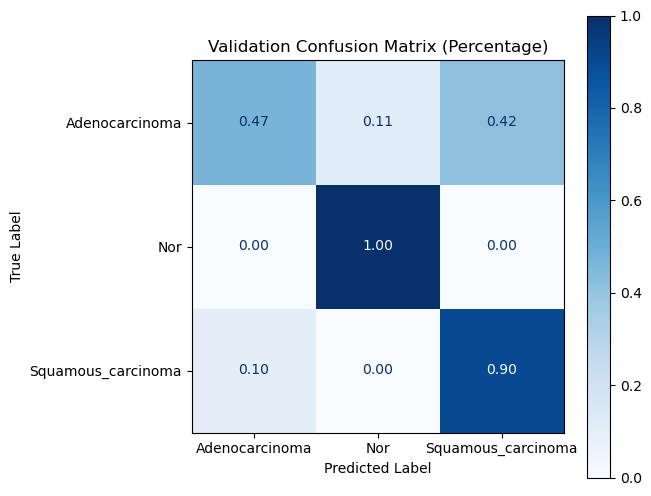

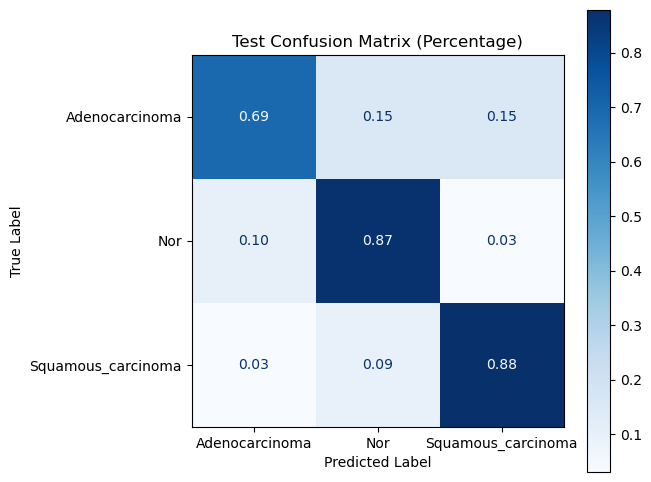

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Get Class Labels ---
class_names = list(val_generator.class_indices.keys())
print("Class Labels:", class_names)

# --- Predict on Validation and Test Sets ---
val_preds = model.predict(val_generator)
test_preds = model.predict(test_generator)

# --- Convert probabilities to class labels ---
val_pred_classes = np.argmax(val_preds, axis=1)
test_pred_classes = np.argmax(test_preds, axis=1)

# --- Get true labels ---
val_true_classes = val_generator.classes
test_true_classes = test_generator.classes

# --- Confusion Matrices ---
val_cm = confusion_matrix(val_true_classes, val_pred_classes)
test_cm = confusion_matrix(test_true_classes, test_pred_classes)

# --- Normalize Confusion Matrices to Percentages ---
val_cm_percent = val_cm.astype('float') / val_cm.sum(axis=1)[:, np.newaxis] 
test_cm_percent = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis] 

# --- Plot Function ---
def plot_confusion_matrix(cm, classes, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax, colorbar=True)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- Plot Confusion Matrices ---
plot_confusion_matrix(val_cm_percent, class_names, "Validation Confusion Matrix (Percentage)")
plot_confusion_matrix(test_cm_percent, class_names, "Test Confusion Matrix (Percentage)")
